In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, l

In [6]:
def read_prep_write_AR6_fig9_26_netcdfs(infilename,veldomain=False):
    """
    Brings in the AR6 component NetCDF files and corrects the data arrangement to match that of the 
    AR5 and AR6 data that we are working with. Importantly, the data were transposed and also have
    a duplicate data column in the longitude dimension to force the wrap-around in matlab. 

    This function takes the name of the file that is to be processed and also a flag if the data are
    to be placed on the domain of the velocity data or the slightly more contrained domain for 
    mapping. Output is a xarray dataset with attributes taken from the original and additional
    attributes given the lat and lon coordinates.
    """
    #Rebuild this bag of arse from the ground up:
    # Create the xarray Dataset (code from MS copilot)
    dsin = xr.open_dataset(infilename)
    dsin = dsin.rename({'Longitude': 'lon', 'Latitude': 'lat',})
    ds = xr.Dataset(
        {
            "SL_change": (("lat", "lon"), np.transpose(dsin.SL_change[0:360,:].values)),
        },
        coords={
            "lon": (("lon",), dsin.lon[0:360].values),
            "lat": (("lat",), dsin.lat.values),
        },
    )
    ds = ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
    ds = ds.rio.write_crs("epsg:4326")
    #Add correct attributes for the lat/lon coordinates
    ds = add_latlon_attrs(ds)

    #Interpolate it to commonly used tenth degree grid.
    #ds = interp_canada_tenth_degree(ds,'nearest',veldomain)
    
    #Add the attributes from the parent data to the Data variable
    ds.SL_change.attrs['title'] = dsin.attrs['title']
    ds.SL_change.attrs['units'] = dsin.attrs['units']
    ds.SL_change.attrs['creator'] = dsin.attrs['creator']
    ds.SL_change.attrs['activity'] = dsin.attrs['activity']
    ds.SL_change.attrs['comments'] = dsin.attrs['comments']
    ds.SL_change.attrs['long_name'] = infilename.split('_')[-3:-1][1] + ' sea-level contribution'
    #Change the name of the dataset to prevent clobber when merged with other data
    #split the file on . and keep the second to last
    dsetname = infilename.split('_')[-3:-1][0]+'_'+infilename.split('_')[-3:-1][1] + '_slr'
    ds = ds.rename({'SL_change': dsetname})
    basename = infilename.split('.')[0]
    outfilename = basename + '_ll_fixed.nc'
    ds.to_netcdf(outfilename)
    return ds

def add_latlon_attrs(ds):
    """
    Simple code to add the correct attributes to an xarray spatial grid 
    with dimensions lat and lon.

    May write an extension of this function to correctly detect if lat/lon 
    exist in the file and modify the existing names to the conforming name lat/lon.
    The existince of a billion names for these ever-so-common grid dimensions
    is hyper annoying.

    Takes an xarray dataset as input and assigns coordinates.
    """
    commonlats = ['Lat','lat','latitude','Latitude','lats', 'Lats']
    commonlons = ['Lon','lon', 'Long', 'long', 'longitude','longitude','lons', 'Lons', 'longs', 'Longs']
    
    #Test to see if lat and lon exist in the names of the 
    if ('lat' in list(ds.coords)) & ('lon' in list(ds.coords)):
        #We have the required latitude and longitude names
        ds.lon.attrs['standard_name'] = 'longitude'
        ds.lon.attrs['long_name'] = 'longitude'
        ds.lon.attrs['units'] = 'degrees_east'
        ds.lon.attrs['axis'] = 'X'
        ds.lat.attrs['standard_name'] = 'latitude'
        ds.lat.attrs['long_name'] = 'latitude'
        ds.lat.attrs['units'] = 'degrees_north'
        ds.lat.attrs['axis'] = 'Y'
        return ds
    else:
        #For now, do nothing. Maybe change to alter the coord that is there to 
        #the desired name and then alter as above.
        return ds

In [3]:
read_prep_write_AR6_fig9_26_netcdfs('C:/Users/fanslow/Work/SLR/Chapter-9/Plotting_code_and_data/Fig9_26_SL_regional/Plotted_Data/Fig9-26_data_ssp585_oceandynamics_map.nc')


NameError: name 'read_prep_write_AR6_fig9_26_netcdfs' is not defined

In [2]:
# Connor found the RSLR components, let's take a look
ds = xr.open_dataset(
    'C:/Users/fanslow/Work/SLR/ar6-regional_novlm-confidence/' +
    'ar6-regional_novlm-confidence/regional_novlm/confidence_output_files/'+
    'medium_confidence/ssp585/oceandynamics_ssp585_medium_confidence_values.nc'
    )
#ds

# This file is in a completely obscene format. In order to package point timeseries for select locations with the grid, the whole array has
# been flattened. The first 1030 entries are the projections at tide gages. The next 360*181 (65160) points are the grid. Each grid point 
# has a location ID associated with it. Those location IDs can be used to extract out the data for a given time slice and quantile.


In [57]:
def get_nodename_list(infilename="C:/Users/fanslow/Work/SLR/location_list.lst"):
    # Read in the locations list
    df = pd.read_csv(infilename,sep='\t', header=None,names=['nodename','grid_id','lat','lon'])
    return df
    
    
def get_grid_nodenames(nodenamedf,minlat,maxlat,minlon,maxlon):
    #Filter the data by the locations that we want.
    keepdf = nodenamedf.loc[
        (nodenamedf['lat'] >=minlat) & 
        (nodenamedf['lat'] <= maxlat) & 
        (nodenamedf['nodename'].str.contains('grid')) &
        (nodenamedf['lon'] >= minlon) & 
        (nodenamedf['lon'] <= maxlon)
        ,:]
    return keepdf

def get_lat_lon_sl_from_nodename(locdf,quantile,year):
    
    datadf = pd.DataFrame(
        {
            'lat': ds.sel(locations=ds.locations.isin(locdf['grid_id']),quantiles=quantile,years=year).lat.values,
            'lon': ds.sel(locations=ds.locations.isin(locdf['grid_id']),quantiles=quantile,years=year).lon.values,
            'rsl': ds.sel(locations=ds.locations.isin(locdf['grid_id']),quantiles=quantile,years=year).sea_level_change.values,
        }
    )
    if (all(datadf['lat'].values == locdf['lat'].values))&\
        (all(datadf['lon'].values == locdf['lon'].values)):
        #We have lat and lon alignment, can insert values into the 
        #existing dataframe
        locdf['rsl'] = datadf['rsl'].values
    else:
        print('data misalignment returning Null')
        return Null  
    
    return locdf

def reinsert_sl_from_nodename(datadf,quantile):
    """
    Using a dataframe with columns that contain grid ids and rsl data
    Insert that data into the correct grid_id slot. Doing this one by
    one because I am not convinced that mapping the vector with isin
    will work correctly. It's only a few points, so perhaps not a 
    terrible inefficiency.
    
    """
    
    for arow in datadf.iterrows():
        if arow['rsl'].isna():
            ds.sel(locations=arow['grid_id'],quantiles=quantile,years=year)['sea_level_change'] = arow['rsl_predicted']
    
    

def interpolate_rsl(rsldf,verbose=False):
    
    #Ditch the nans
    rsldf = rsldf.loc[~(rsldf['rsl'].isna()),]
    
    #Fit an initial model
    gam = LinearGAM(s(0) + s(1)).fit(rsldf[['lon', 'lat']], rsldf['rsl'])
    
    #Do a gridsearch to tune it
    lam = np.logspace(0, 5, 11)
    lams = [lam] * 2

    gam.gridsearch(rsldf[['lon', 'lat']], rsldf['rsl'], lam=lams, progress=verbose)
    if verbose:
        print(gam.summary)
    return gam

In [ ]:
quantile = 0.5
year = 2100
nodenamedf = get_nodename_list()
locdf = get_grid_nodenames(nodenamedf,minlat=42.0, maxlat=51.0,minlon=-74.0, maxlon=-65.0)
datadf = get_lat_lon_sl_from_nodename(locdf,quantile=quantile,year=year)
gam = interpolate_rsl(datadf)
datadf['rsl_predicted'] = gam.predict(datadf[['lon','lat']])
reinsert_sl_from_nodename(datadf,quantile=quantile,year=year,)
print(datadf.columns)


Index(['nodename', 'grid_id', 'lat', 'lon', 'rsl', 'rsl_predicted'], dtype='object')


In [47]:

datadf_nonan = datadf.loc[~(datadf['rsl'].isna()),].copy()
datadf_nonan['diff'] = datadf_nonan['rsl'] - datadf_nonan['rsl_predicted']
MAE = datadf_nonan['diff'].abs().mean()
RMSE = np.sqrt((datadf_nonan['diff']**2).mean())
ME = datadf_nonan['diff'].median()


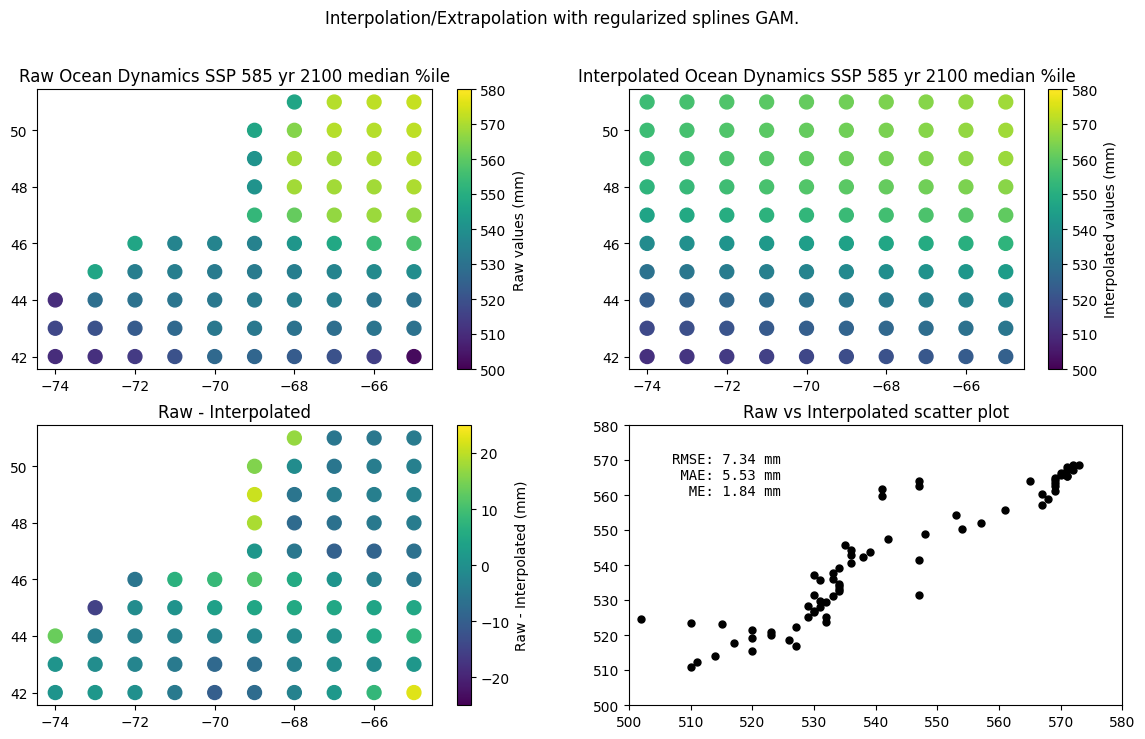

In [48]:

fig, axes = plt.subplots(2, 2, figsize=(14, 8),)#sharex=True,sharey=True)
vmin = 500
vmax= 580
ptsize=100
scat0 = axes[0,0].scatter(datadf['lon'], datadf['lat'], c=datadf['rsl'], s=ptsize,vmin=vmin,vmax=vmax)
axes[0,0].set_title('Raw Ocean Dynamics SSP 585 yr 2100 median %ile')
fig.colorbar(scat0, ax=axes[0,0], label='Raw values (mm)')
scat1 = axes[0,1].scatter(datadf['lon'], datadf['lat'], c=datadf['rsl_predicted'], s=ptsize,vmin=vmin,vmax=vmax)
axes[0,1].set_title('Interpolated Ocean Dynamics SSP 585 yr 2100 median %ile')
fig.colorbar(scat1, ax=axes[0,1], label='Interpolated values (mm)')
scat2 = axes[1,0].scatter(datadf['lon'], datadf['lat'], c=(datadf['rsl_predicted'] - datadf['rsl']), s=ptsize,vmin=-25,vmax=25)
axes[1,0].set_title('Raw - Interpolated')
fig.colorbar(scat2, ax=axes[1,0], label='Raw - Interpolated (mm)')
axes[1,1].scatter(datadf['rsl'], datadf['rsl_predicted'], c='black',s=ptsize/4)
axes[1,1].set_title('Raw vs Interpolated scatter plot')
axes[1,1].set_xlim(vmin,vmax)
axes[1,1].set_ylim(vmin,vmax)
font_props = {
    'family': 'monospace',  # e.g., 'serif', 'sans-serif', 'monospace'
    'color': 'black',
    'size': 15,
}

axes[1,1].annotate(f'RMSE: {RMSE:.2f} mm\n MAE: {MAE:.2f} mm\n  ME: {ME:.2f} mm',xy=((vmin+7),(vmax-20)),xytext=((vmin+7),(vmax-20)),fontfamily='monospace',)
plt.suptitle('Interpolation/Extrapolation with regularized splines GAM.')
plt.savefig('C:/Users/fanslow/Work/SLR/interpolation_spline_comparison.jpg')
plt.show()

In [ ]:


def print_latnodedata(latnodes,quantile):
    print(ds.sel(locations=ds.locations.isin(latnodes),quantiles=quantile,years=2100).lat.values[0],
          ds.sel(locations=ds.locations.isin(latnodes),quantiles=quantile,years=2100).sea_level_change.values)
#    print(ds.sel(locations=ds.locations.isin(latnodes),quantiles=0.50,years=2100).sea_level_change.values)
quantile = 0.5    
latnodes = [173]
#latnodes = [1004102870,1004102880,1004102890,1004102900,1004102910,1004102920,1004102930]
print('----',ds.sel(locations=ds.locations.isin(latnodes),quantiles=quantile,years=2100).lon.values)   
print_latnodedata(latnodes,quantile)
latnodes = [i + 100000 for i in latnodes]
print_latnodedata(latnodes,quantile)
latnodes = [i + 100000 for i in latnodes]
print_latnodedata(latnodes,quantile)
latnodes = [i + 100000 for i in latnodes]
print_latnodedata(latnodes,quantile)
latnodes = [i + 100000 for i in latnodes]
print_latnodedata(latnodes,quantile)
# print(ds.sel(locations=ds.locations.isin([1004202880,1004202890,1004202900,1004202910,1004202920]),quantiles=0.50,years=2100).lat.values)
# print(ds.sel(locations=ds.locations.isin([1004202880,1004202890,1004202900,1004202910,1004202920]),quantiles=0.50,years=2100).lon.values)
# print(ds.sel(locations=ds.locations.isin([1004202880,1004202890,1004202900,1004202910,1004202920]),quantiles=0.50,years=2100).sea_level_change.values)

# print(ds.sel(locations=ds.locations.isin([1004302880,1004302890,1004302900,1004302910,1004302920]),quantiles=0.50,years=2100).lat.values)
# print(ds.sel(locations=ds.locations.isin([1004302880,1004302890,1004302900,1004302910,1004302920]),quantiles=0.50,years=2100).lon.values)
# print(ds.sel(locations=ds.locations.isin([1004302880,1004302890,1004302900,1004302910,1004302920]),quantiles=0.50,years=2100).sea_level_change.values)
